<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/stocks_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Javascript

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
tf.keras.backend.set_floatx('float64')

!pip install yahooquery
from yahooquery import Ticker

!rm -rf stocks
!git clone https://github.com/Talendar/stocks_prices_prediction stocks

from stocks.aux.stocks_data import StocksData
from stocks.aux.eval import *
from stocks.aux.normalization import min_max_norm, min_max_denorm
from stocks.aux.tf_callbacks import ClearCallback

# https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol=IBM&interval=15min&slice=year2month2&apikey=0QPBT7ES37C1DOZH

In [2]:
NUM_SESSIONS = 15  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = 0.8, 0.12, 0.08
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

## **1) Preparing the data**

#### **1.1) Fetching stocks prices**

   [TIME INTERVAL] from 2007-01-02 to 2020-12-04
[TRADING SESSIONS] 3440

>>> DATA:


,low,volume,high,open,close,adjclose
date,,,,,,
2007-01-02,44476.0,75560200.0,45388.0,44476.0,45383.0,45383.0
2007-01-03,44284.0,122372800.0,45379.0,45379.0,44445.0,44445.0
2007-01-04,43623.0,86577000.0,44442.0,44442.0,44020.0,44020.0
2007-01-05,42160.0,164055000.0,44081.0,44019.0,42245.0,42245.0
2007-01-08,42144.0,114007100.0,42926.0,42249.0,42830.0,42830.0
...,...,...,...,...,...,...
2020-11-30,108829.0,19300000.0,110934.0,110598.0,108888.0,108888.0
2020-12-01,108897.0,11324800.0,111840.0,108897.0,111335.0,111335.0
2020-12-02,110579.0,9814300.0,112315.0,111402.0,111814.0,111814.0




>>> STATS:


,low,volume,high,open,close,adjclose
count,3440.000000,3.440000e+03,3440.000000,3440.000000,3440.000000,3440.000000
mean,63885.059884,8.225777e+06,65227.513372,64554.034302,64574.340116,64574.340116
std,17465.858616,2.272999e+07,17650.797967,17550.578955,17573.157961,17573.157961
min,29435.000000,0.000000e+00,31480.000000,29438.000000,29435.000000,29435.000000
25%,52189.250000,2.243300e+06,53311.750000,52756.750000,52763.000000,52763.000000
50%,59786.500000,3.310100e+06,61187.500000,60412.500000,60434.000000,60434.000000
75%,69674.000000,4.575725e+06,70944.500000,70375.500000,70385.000000,70385.000000
max,118108.000000,2.322653e+08,119593.000000,119528.000000,119528.000000,119528.000000


<IPython.core.display.Javascript object>

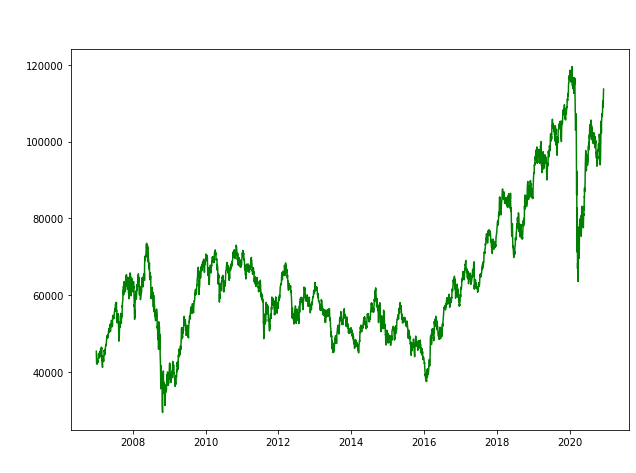

In [6]:
data = Ticker("^BVSP").history(start="2007-01-01",
                               #end="2020-12-04",
                               interval="1d")
data.reset_index("symbol", inplace=True, drop=True)

print("   [TIME INTERVAL] from %s to %s" % (data.index[0], data.index[-1]))
print("[TRADING SESSIONS] %d\n" % len(data))

print(">>> DATA:")
display(data)

print("\n\n>>> STATS:")
display(data.describe())

print("\n\n")
ax = data["close"].plot(figsize=(10,7), color="green")
ax.set_title("Evolution of the closing prices\n", fontsize=20, color="#ffffff");
ax.set_ylabel("Closing prices", fontsize="15", color="#ffffff");
ax.set_xlabel("Date", fontsize="15", color="#ffffff");

Javascript("google.colab.output.setIframeHeight('500px');")

#### **1.2) Pre-processing data**

In [7]:
data = StocksData(
    data_df=data,
    num_sessions=NUM_SESSIONS,
    labels_names=LABELS_NAMES,
    feature_normalization=(min_max_norm, min_max_denorm), 
    label_normalization=(min_max_norm, min_max_denorm) \
                        if NORMALIZE_LABELS else None,  
    data_split_pc=(TRAIN_PC, VAL_PC, TEST_PC),
)

print("  [TRAINING RANGE] %s to %s" % (
    data.raw_train["features"].index[0], data.raw_train["features"].index[-1]))
print("[VALIDATION RANGE] %s to %s" % (
    data.raw_val["features"].index[0], data.raw_val["features"].index[-1]))
print("      [TEST RANGE] %s to %s" % (
    data.raw_test["features"].index[0], data.raw_test["features"].index[-1]))

  [TRAINING RANGE] 2007-01-02 to 2018-01-29
[VALIDATION RANGE] 2018-02-23 to 2019-10-01
      [TEST RANGE] 2019-10-23 to 2020-11-12


In [8]:
print(">>> NORMALIZED TRAINING DATA:")
display(data.norm_train["features"].tail())

print("\n\n>>> NORMALIZED VALIDATION DATA:")
display(data.norm_val["features"].tail())

print("\n\n>>> NORMALIZED TEST DATA:")
display(data.norm_test["features"].tail())

Javascript("google.colab.output.setIframeHeight('300px');")

>>> NORMALIZED TRAINING DATA:


,low,volume,high,open,close
date,,,,,
2018-01-22,0.937748,0.011594,0.928660,0.923145,0.931261
2018-01-23,0.930481,0.015978,0.928678,0.931275,0.913488
2018-01-24,0.933304,0.023696,0.965755,0.913501,0.967003
2018-01-26,0.987961,0.023295,1.000000,0.967001,1.000000
2018-01-29,1.000000,0.016746,1.000000,1.000000,0.985150




>>> NORMALIZED VALIDATION DATA:


,low,volume,high,open,close
date,,,,,
2019-09-25,1.340455,0.017728,1.350595,1.326707,1.337814
2019-09-26,1.364186,0.017819,1.366524,1.337903,1.352752
2019-09-27,1.367264,0.014945,1.371908,1.352771,1.348456
2019-09-30,1.369668,0.016773,1.363490,1.348457,1.342520
2019-10-01,1.355080,0.017634,1.362435,1.342538,1.330184




>>> NORMALIZED TEST DATA:


,low,volume,high,open,close
date,,,,,
2020-11-06,1.282228,0.036091,1.284861,1.271335,1.272176
2020-11-09,1.302572,0.074960,1.362917,1.274954,1.327688
2020-11-10,1.348086,0.071751,1.374221,1.320628,1.353323
2020-11-11,1.360653,0.046675,1.368744,1.348279,1.338723
2020-11-12,1.322242,0.046758,1.360548,1.343697,1.296706


<IPython.core.display.Javascript object>

In [9]:
sample_x, sample_y = next(iter(data.train_ds))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (32, 15, 5)
Sample label shape: (32, 3)


## **2) Defining a model**

In [10]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS):
        super(MultiLSTM, self).__init__()
        self._num_sessions = num_sessions

        self._open_predictor = model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="relu"),  
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),  
        ])

        self._pre_lowest = tf.keras.layers.LSTM(64, return_sequences=True)
        self._lowest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
             tf.keras.layers.Dense(128, activation="relu"),  
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"), 
        ])

        self._pre_highest = tf.keras.layers.LSTM(64, return_sequences=True)
        self._highest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(128, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="relu"),  
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),
        ])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])

        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)

In [8]:
# testing output shape
x, y = next(iter(data.train_ds))
MultiLSTM()(x).shape

TensorShape([32, 3])

## **3) Training the model**

86/86 [==============================] - 2s 27ms/step - loss: 0.0019 - mean_absolute_error: 0.0334 - val_loss: 0.0018 - val_mean_absolute_error: 0.0346





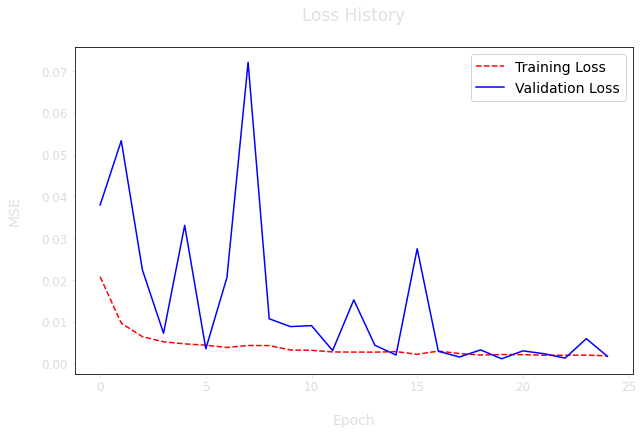

In [11]:
# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
epochs = 25
history = model.fit(data.train_ds.shuffle(buffer_size=len(data.train_ds)), 
                    validation_data=data.val_ds,
                    epochs=epochs,
                    callbacks=[ClearCallback()])

# visualizing loss history
print("\n\n")
plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

## **3) Evaluating the model**

#### **3.1) Training data**

     Training Data

#########################

[> GENERAL <]
   . MAE:   1388
   . MAPE:  2.4544%
   . MSE:   2976043

#########################

[> OPEN <]
   . MAE:   1388
   . MAPE:  2.4542%
   . MSE:   2975678

#########################

[> LOW <]
   . MAE:   1388
   . MAPE:  2.4547%
   . MSE:   2976624

#########################

[> HIGH <]
   . MAE:   1388
   . MAPE:  2.4544%
   . MSE:   2976043

#########################


<IPython.core.display.Javascript object>

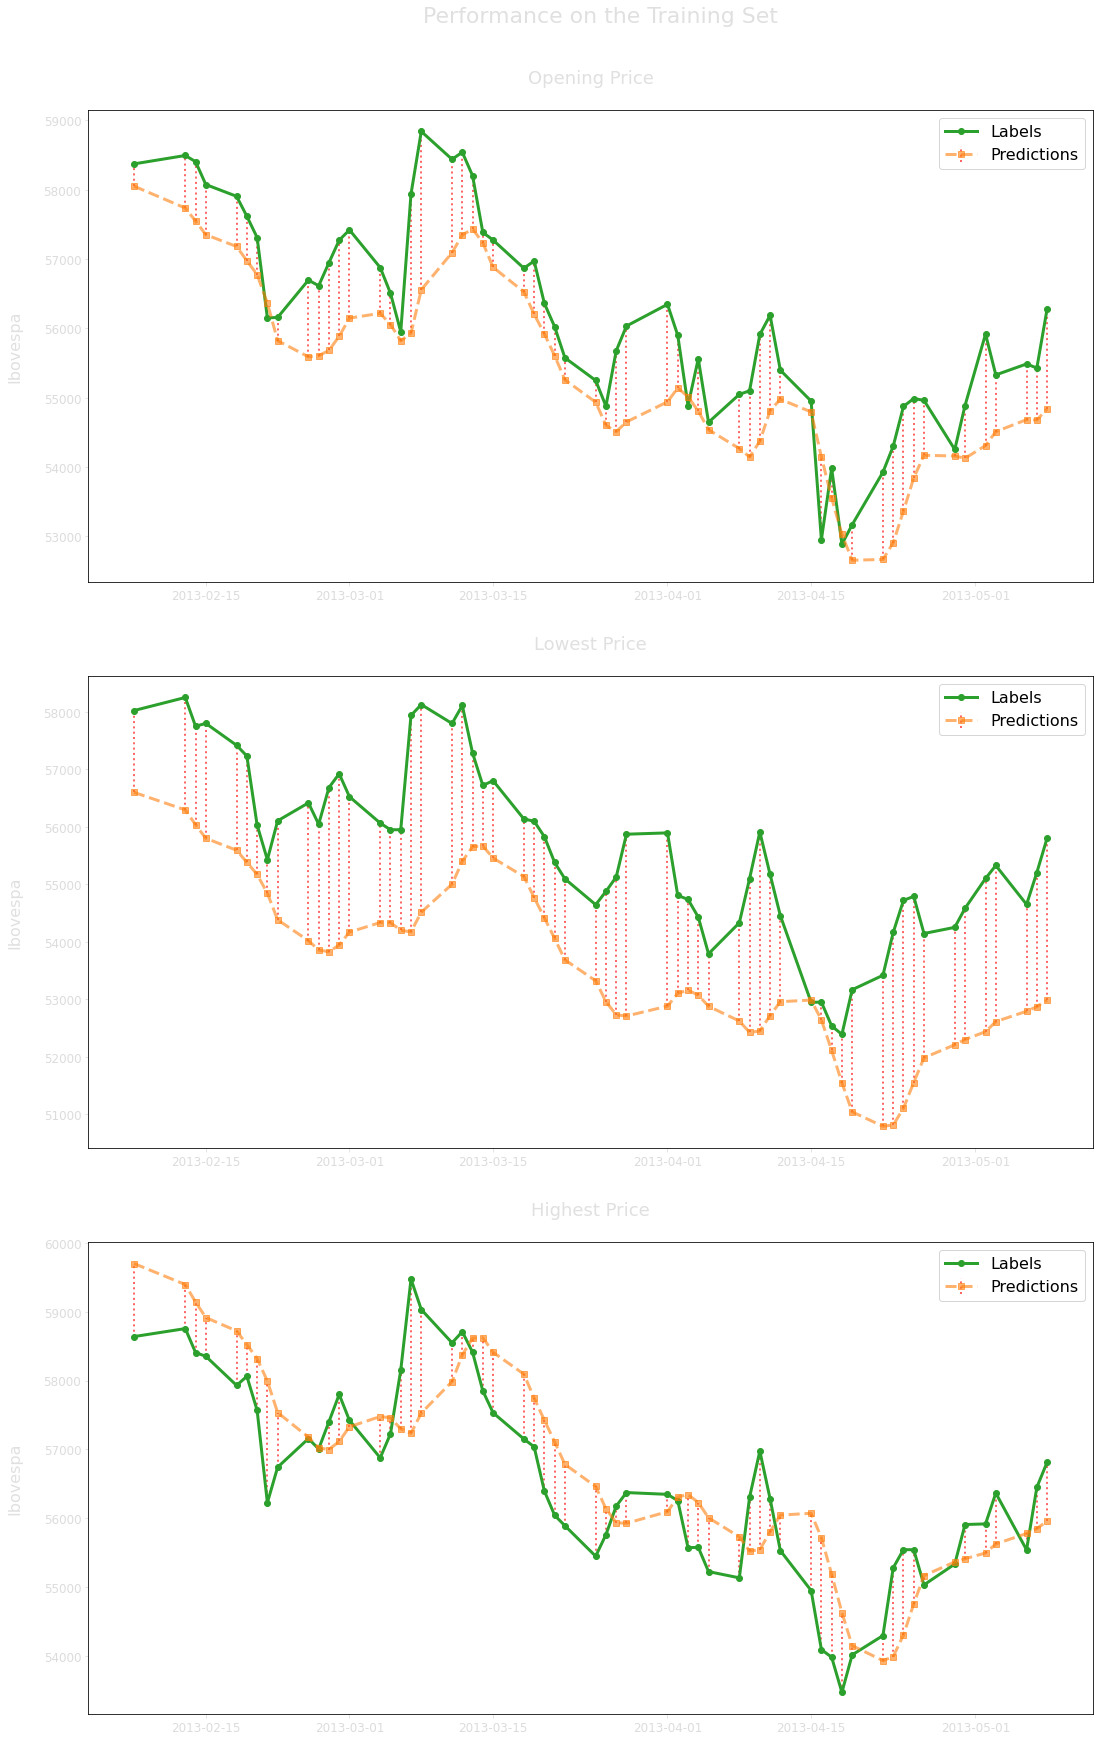

In [13]:
train_predictions, train_results = eval(model, data, "train")

print("     Training Data\n")
eval_print(train_results)

eval_plot(train_predictions, 
          data.raw_train["labels"], 
          start_date="random", 
          plot_samples=60, 
          title="Performance on the Training Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.2) Validation data**

     Validation Data

#########################

[> GENERAL <]
   . MAE:   1458
   . MAPE:  2.4214%
   . MSE:   3303885

#########################

[> OPEN <]
   . MAE:   1459
   . MAPE:  2.4217%
   . MSE:   3306341

#########################

[> LOW <]
   . MAE:   1459
   . MAPE:  2.4215%
   . MSE:   3306432

#########################

[> HIGH <]
   . MAE:   1459
   . MAPE:  2.4212%
   . MSE:   3306134

#########################


<IPython.core.display.Javascript object>

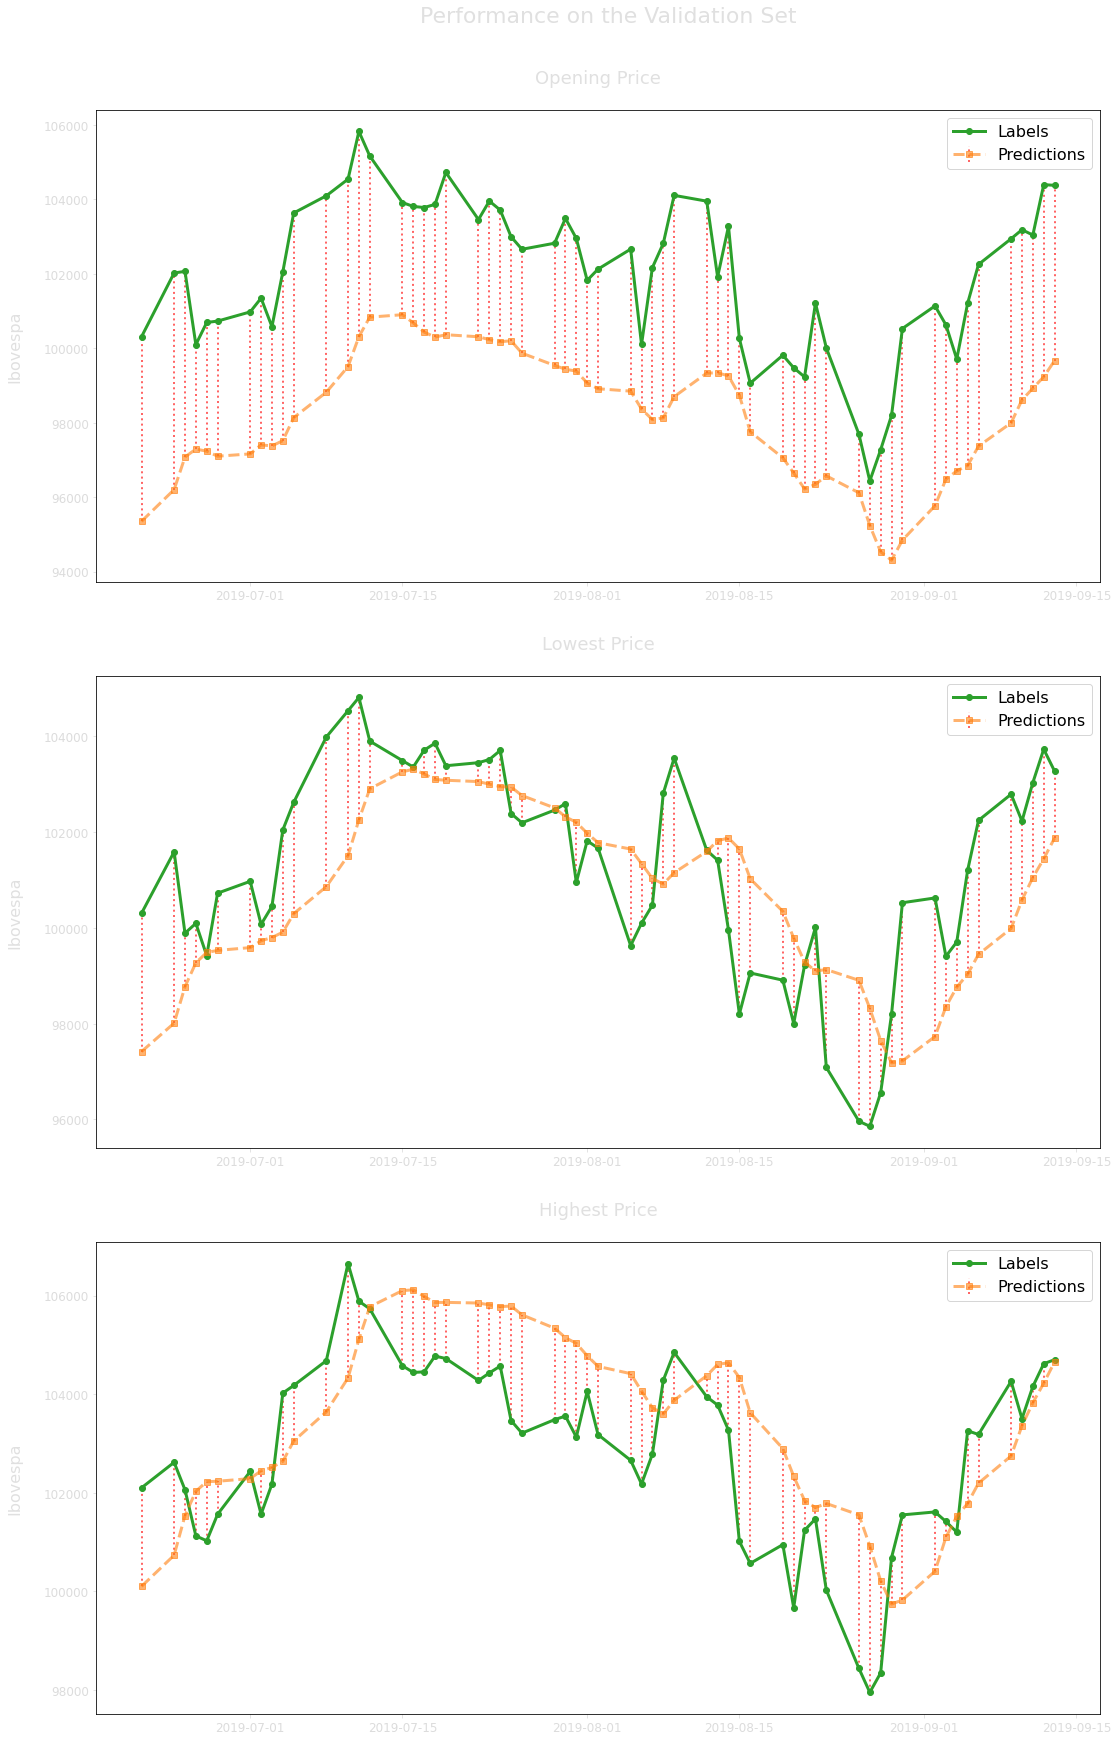

In [14]:
val_predictions, val_results = eval(model, data, "val")

print("     Validation Data\n")
eval_print(val_results)

eval_plot(val_predictions, 
          data.raw_val["labels"], 
          start_date="random", 
          plot_samples=60, 
          title="Performance on the Validation Set")

Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.3) Test data**

     Test Data

#########################

[> GENERAL <]
   . MAE:   1555
   . MAPE:  2.4617%
   . MSE:   4119467

#########################

[> OPEN <]
   . MAE:   1556
   . MAPE:  2.4621%
   . MSE:   4123358

#########################

[> LOW <]
   . MAE:   1556
   . MAPE:  2.4623%
   . MSE:   4127333

#########################

[> HIGH <]
   . MAE:   1557
   . MAPE:  2.4622%
   . MSE:   4128611

#########################


<IPython.core.display.Javascript object>

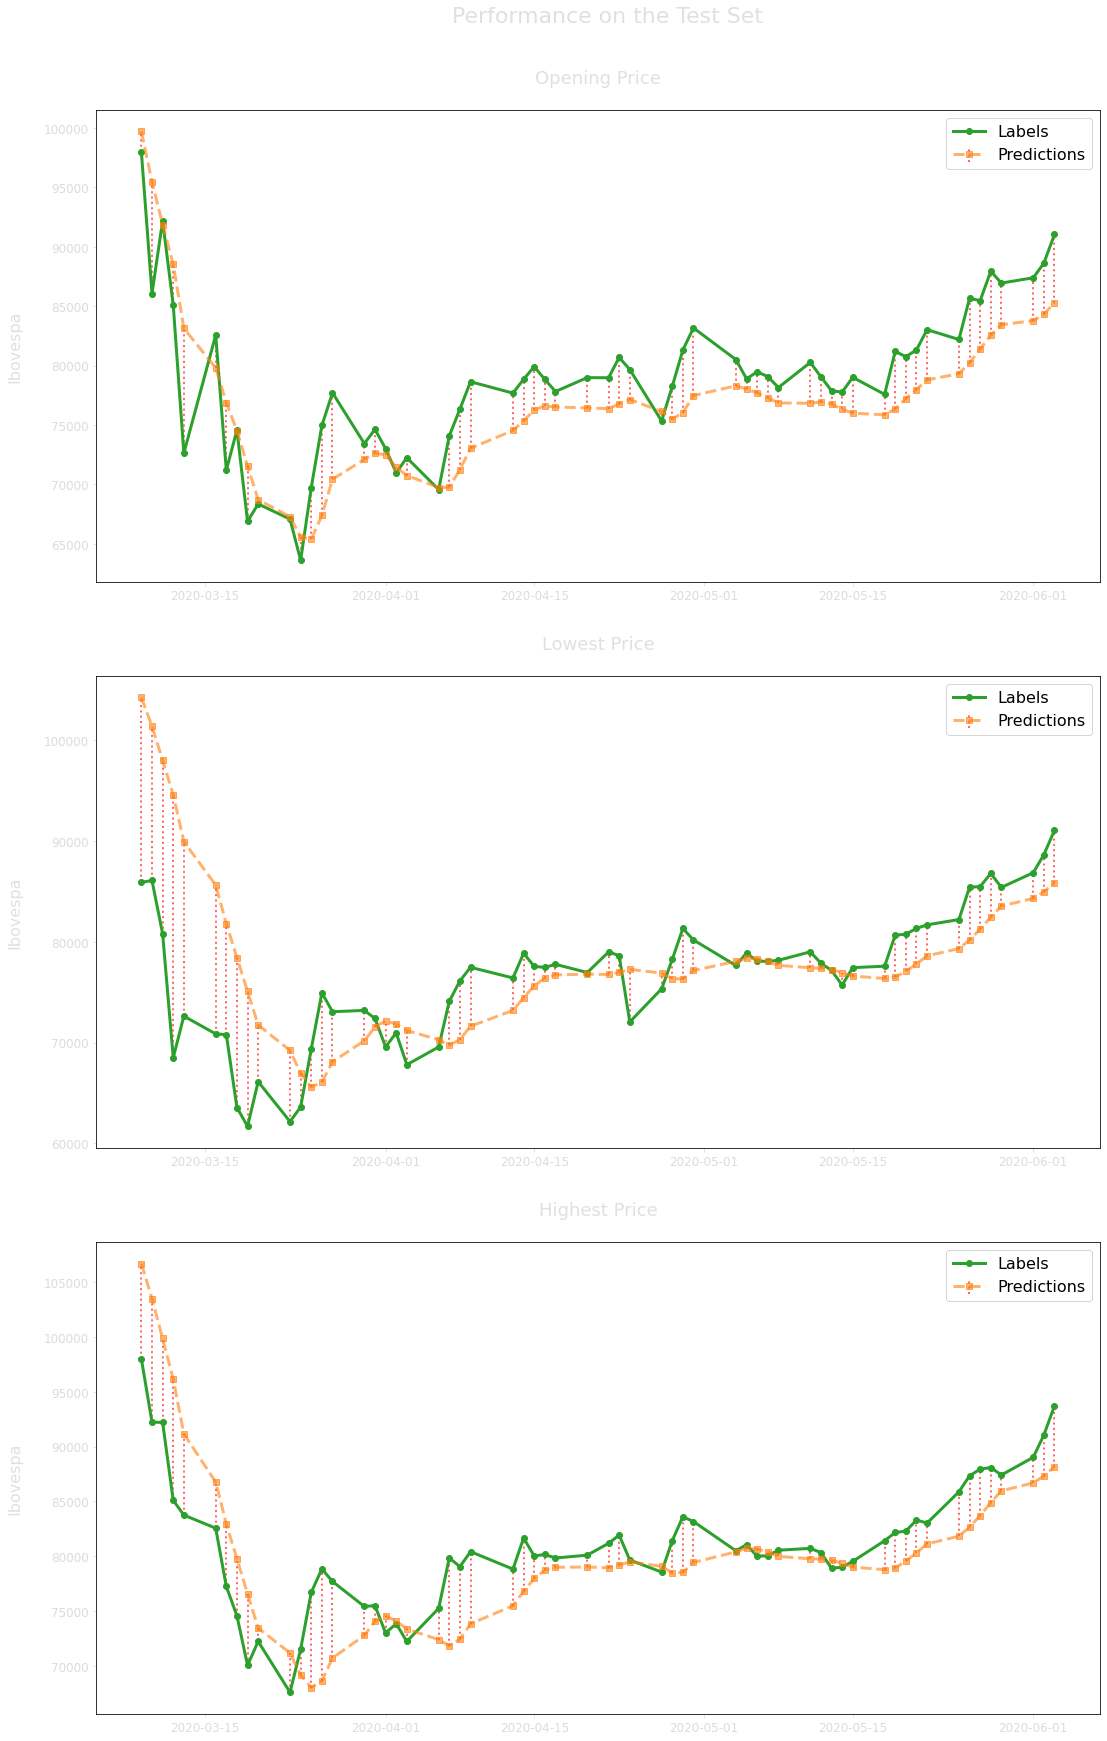

In [15]:
test_predictions, test_results = eval(model, data, "test")

print("     Test Data\n")
eval_print(test_results)

eval_plot(test_predictions, 
          data.raw_test["labels"], 
          start_date="random", 
          plot_samples=60, 
          title="Performance on the Test Set")

Javascript("google.colab.output.setIframeHeight('600px');")